**Версия 2.0:**
*Что нового*
- Вывожу ID звонка ✔️
- Если фраза встречается 2 раза в одном звонке, то в выборку попадают оба ответа ✔️
- Фикс Бага с дублями ✔️

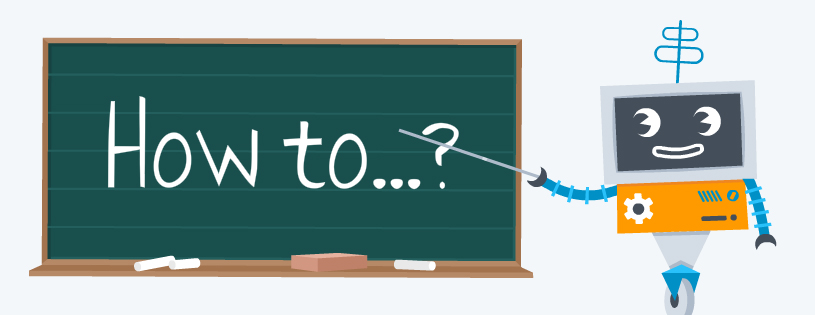

# Как это работает

1. Выгружаем из РА .ass файлы, кладем в ./ASS папочку
2. Запускаем блок "запустить 1 раз" только 1 раз)))
3. Движемся вниз по ноутбуку, нажимая кнопку "Run" для нужного блока
4. При необходимости (и желании поувствовать себя Data-сатанистом) можно сходить с выгрузкой в Orange (workflow лежит где-то рядом)

# Запустить 1 раз!!!

In [ ]:
pip install nltk collections seaborn

In [ ]:
pip install collections

In [ ]:
pip install seaborn

# Сама утилита

In [ ]:
# Dependencies - то, без чего не будет работать 
import os
import re

import nltk
from nltk.stem.snowball import SnowballStemmer

from nltk.corpus import stopwords
from string import punctuation

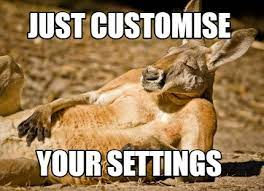

# Тут живут все настройки

Меняем то, что **жирным**

target_list - не трогаем

**target_phrase_segment** - искомая фраза/часть фразы после который мы анализируем **канал**

ass_list - в скобках путь к субтитрам, ./ - означает "отсюда"

**look_forward** - на сколько реплик/строк **ВНЕ ЗАВИСИМОСТИ ОТ РОЛИ** вперед смотрим, из-за фичи алгоритма, число должно быть х2 от желаемого, то есть, 
если мы хотим смотреть на 2 фразы после искомой фразы робота - пишем 4, если 3 то 6...

**target_channel** - тот канал, КОТОРЫЙ анализируем

stemmer - аналогично

In [ ]:
# Globals
target_list = []
target_list_id = [] # 2.0
target_phrase_segment = 'хотим сообщить, что для вас одобрен кредит со специальными условиями в размере'

# Settings
ass_list = os.listdir('./ASS_Files')
look_forward = 6 # /2
target_channel = 'Абонент'
stemmer = SnowballStemmer("russian") 

In [ ]:
# Мега-цикл

current_iter = []  # Fix 2.0

for i in ass_list:
    with open(f'./ASS_Files/{i}', 'r+', encoding='utf-8') as subtitle:
        lines = subtitle.readlines()
        for j in lines:
            # Ищем строку, где упомянут сегмент целевой фразы
            if target_phrase_segment in j:
                call_id = lines[1][7:-1]
                occurrence = lines.index(j)
                x = 1
                
                # Проверяем транскрипцию на look_forward вперед, и забираем строки из канала target_channel
                current_iter = []
                while x <= look_forward:
                    try:
                        check = lines[occurrence+x]
                        
                    except IndexError:
                        print('Out of Range')
                        
                    # Если мы метчим фразу, то нужно произвести с ней nltk-манипуляции++ и засунуть в финальный корпус    
                    if target_channel in check:
                        words = re.findall(r",,(.*?$)", str(check))[0]
                        current_iter.append(words)
                    x += 1
                    
                target_list.append(current_iter)  # Fix 2.0
                target_list_id.append(call_id)  # 2.0
            else:
                pass


In [ ]:
print(target_list)

# Причесываем простыню

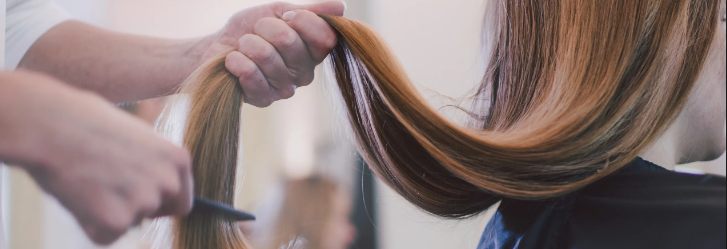

In [ ]:
final_list= []

In [ ]:
# список слов, который нужно вынести из простыни, чтобы не засорять эфир

russian_stopwords = ['и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', \
 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было',\
 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли',\
 'если', 'уже', 'или', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там',\
 'потом', 'себя', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя',\
 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж',\
 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один',\
 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'можно',\
 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас',\
 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'свою', 'этой',\
 'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']

# Тут происходит следующее:

1. Отрицательные частицы сшиваются со словами (Заранее прошу прощение у ~~Рамзана~~~ NLP-спецов)
2. Все слова из предыдущего списка выносятся из простыни

In [ ]:
russian_stopwords = []
for i in target_list:
    temp = ''
    for j in i:
        temp += f' {j}'
    temp = re.sub(r"( не) (.*?)", "\\1\\2", temp)
    temp = re.sub(r"( ни) (.*?)", "\\1\\2", temp)
    temp = temp.lower()
    for wor in russian_stopwords:
        try:
            temp = temp.replace(f' {wor} ', ' ')
        except:
            pass

    final_list.append(temp)

In [ ]:
# Этот блок можно запустить, чтобы консоль напечатала [список] прям тут (комп может загрустить на 5-10 сек):
print(final_list)

# Далее все нажимать не надо, делаем только то, что необходимо




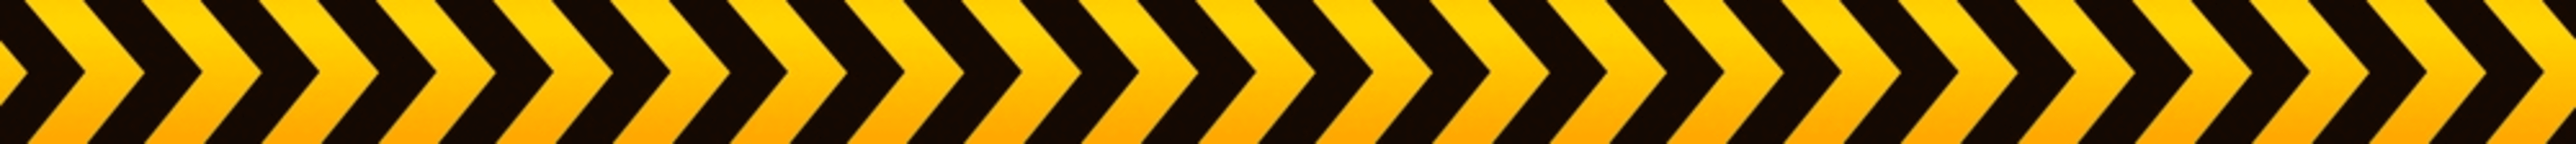

# Подготовка выгрузки файлом

In [ ]:
file_name = 'выгрузка'  # придумываем название, упадет в корневую папку

with open (f'./{file_name}.txt', 'w+', encoding='utf-8') as cd:
    for index, line in enumerate(final_list):
        cd.write(f'{target_list_id[index]}\t{index}\t{line}\n')
print('Выгрука готова')

# Вывести простыню в консоль построчно

In [ ]:
for index, line in enumerate(final_list):
    print(f'{target_list_id[index]}\t{index}\t{line}')
    
# В принципе, контрол+С -> контрол+V можно и отсюда...

#  Посчитать статистику

Методом... бревна и палок

1. Импотрируем библиотеку, которая делает подсчет быстее 
2. Задаем переменную **topx** - топ сколько слов выводить
3. Тыкаем все блоки
4. Удивляемся, почему Seaborn строит такие маленькие диаграммы 

In [ ]:
from collections import Counter

In [ ]:
topx = 20  # Вот тут редактируем

In [ ]:
full_canvas = ''
for i in final_list:
    full_canvas += f' {i}'
    
list_canvas = full_canvas.split()

In [ ]:
counter = Counter(list_canvas)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = counter.most_common(topx)

# Можно вывести результаты подсчетов списком

In [ ]:
print(most_occur)

# Можно графиком

In [ ]:
import seaborn as sns

In [ ]:
xes = []
ys = []

for i in most_occur:
    xes.append(i[0])
    ys.append(i[1])

total = {
    'X': xes,
    'Y': ys
       }
       
plt = sns.barplot(data=total, x='X', y='Y', orient="v")
plt.set_xticklabels(
    labels=xes, rotation=60)

print(f'Топ {topx} слов в выборке:')